In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from datetime import date, timedelta
import glob
import os

import dask

import matplotlib.pyplot as plt

In [5]:
# Directories
from utils.global_paths import nldas_path, project_data_path, smap_path, lai_path, log_path

In [3]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="30GB",
    walltime="00:20:00",
)

cluster.scale(jobs=10)

# print(cluster.job_script())

from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.26:39483,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# SMAP

## Calculate daily averages

In [66]:
def calculate_daily_avg(date, in_path, out_path, log_path):
    def _preprocess(ds):
        # Add datetime
        dt_all = ds.encoding["source"][70:]
        datetime = pd.to_datetime(f"{dt_all[:4]}-{dt_all[4:6]}-{dt_all[6:8]} {dt_all[9:11]}:30",
                                  format="%Y-%m-%d %H:%M")
        ds = ds.expand_dims(time=[datetime])
        # Select band data
        ds = ds.isel(band=0)
        # Rename coords
        ds = ds.rename({"x": "lon", "y": "lat"})
        # Rename variable
        var_name = "_".join(ds.encoding["source"].split("_Geophysical_Data_")[1].split("_")[:-1])

        ds = ds.rename({"band_data": var_name})

        # Drop unwanted variables
        ds = ds.drop_vars(["band", "spatial_ref"])
        # Return
        return ds

    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace("-", "")

    # Check if done
    if os.path.isfile(f"{out_path}/SMAP_L4_SM_gph_all_{date_strf}.nc"):
        return None

    # Read entire day (check if complete)
    files = glob.glob(f"{in_path}/SMAP_L4_SM_gph_{date_strf}*.tif")
    if len(files) < ((8*6) - 1):
        with open(f"{log_path}/SMAP_L4_SM_gph_{date_strf}.txt", "w") as f:
            f.write(f"Only {len(files)} files")
            return None

    # Auto-combine
    ds = xr.combine_by_coords([_preprocess(xr.open_dataset(file)) for file in files])

    # FIX NANS
    # There are some locations were SM falls outside metadata bounds. Related to very high porosity values.
    ds['sm_rootzone'] = ds['sm_rootzone'].where(ds['sm_rootzone'] <= 0.9)
    ds['sm_rootzone'] = ds['sm_rootzone'].where(ds['sm_rootzone'] >= 0.0)
    
    # Resample to daily means
    ds_out = ds.resample(time="1D").mean()

    # Store
    ds_out.to_netcdf(f"{out_path}/SMAP_L4_SM_gph_all_{date_strf}.nc")

In [67]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(calculate_daily_avg)(
            date=start_date,
            in_path=f"{smap_path}/raw_regridded",
            out_path=f"{smap_path}/processed",
            log_path=log_path,
        )
    )
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 6.3 s, sys: 230 ms, total: 6.53 s
Wall time: 18.8 s


## Re-grid to NLDAS grid

In [69]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(
    f"{nldas_path}/VIC/daily/NLDAS_VIC0125_H.A20221231.nc"
)  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset({
        "lat": (["lat"], nldas_lat_grid,
                {"standard_name": "latitude", "units": "degrees_north"},),
        "lon": (["lon"], nldas_lon_grid,
                {"standard_name": "longitude", "units": "degrees_east"},),
})
# Add mask from NLDAS output (otherwise weird NaN behavior)
ds_out["mask"] = xr.where(~np.isnan(nldas_grid["RZSM"].isel(lev_2=0, time=0)), 1, 0)
ds_out = ds_out.drop_vars(["time", "lev_2"])

In [70]:
def regrid_to_nldas(date, ds_out, in_path, out_path):
    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace("-", "")

    # Check if done
    if os.path.isfile(f"{out_path}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc"):
        return None

    # Read
    dr_in = xr.open_dataset(f"{in_path}/SMAP_L4_SM_gph_all_{date_strf}.nc")
    dr_in = dr_in.sortby("lat").sel(lat=slice(20, 60), lon=slice(-130, -60))  # generous North America slice

    # Regrid conservatively
    regridder = xe.Regridder(dr_in, ds_out, "conservative")
    dr_out = regridder(dr_in, skipna=True, na_thres=0.5) # This threshold is somewhat subjective

    # Store
    dr_out.to_netcdf(f"{out_path}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc")

In [71]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(regrid_to_nldas)(
            date=start_date,
            ds_out=ds_out,
            in_path=f"{smap_path}/processed",
            out_path=f"{smap_path}/processed_nldas_grid",
        )
    )
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 48.2 s, sys: 3.26 s, total: 51.4 s
Wall time: 4min 28s


# NLDAS daily averages

In [34]:
def calculate_nldas_daily_avg(date, model, nldas_path, out_path, log_path):
    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace("-", "")

    # Check if done
    if os.path.isfile(f"{out_path}/NLDAS_{model}0125_H.A{date_strf}.nc"):
        return None

    # Calculate averages
    try:
        # Read entire day (check if complete)
        files = glob.glob(f"{nldas_path}/NLDAS_{model}0125_H.A{date_strf}*")
        # There were some days (5 days total across models & forcing) where only 23/24 hours downloaded
        # We assume this is negligible for calculating the daily average
        if len(files) < 23:
            with open(f"{log_path}/NLDAS_{model}0125_H_{date_strf}.txt", "w") as f:
                f.write(f"Only {len(files)} files")
                return None

        # Auto-combine
        ds = xr.concat([xr.open_dataset(file) for file in files], dim="time")

        # Resample to daily
        if model == "FORA":
            ds_apcp = xr.Dataset({"APCP": ds["APCP"].resample(time="1D").sum()})
            ds_tmp = (
                xr.Dataset({"TMP": ds["TMP"].resample(time="1D").mean()})
                .isel(height=0)
                .drop("height")
            )

            # Merge
            ds_out = xr.merge([ds_apcp, ds_tmp])
        else:
            ds_out = ds.resample(time="1D").mean()

        # Store
        ds_out.to_netcdf(f"{out_path}/NLDAS_{model}0125_H.A{date_strf}.nc")
    except Exception as e:
        with open(f"{log_path}/NLDAS_{model}0125_H_{date_strf}.txt", "w") as f:
            f.write(str(e))
            return None

## Meteorological forcing

In [37]:
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(calculate_nldas_daily_avg)(
            date=start_date,
            model="FORA",
            nldas_path=f"{nldas_path}/forcing/hourly",
            out_path=f"{nldas_path}/forcing/daily/",
            log_path=log_path,
        )
    )
    start_date += delta

In [38]:
len(delayed)

2557

In [39]:
%%time
# Compute
_ = dask.compute(*delayed)

CPU times: user 2.89 s, sys: 78.5 ms, total: 2.97 s
Wall time: 3.33 s


## Soil moisture model outputs

### Calculation

In [40]:
model = "NOAH"

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(calculate_nldas_daily_avg)(
            date=start_date,
            model=model,
            nldas_path=f"{nldas_path}/{model}/hourly",
            out_path=f"{nldas_path}/{model}/daily/",
            log_path=log_path,
        )
    )
    start_date += delta

print(len(delayed))

2557


In [41]:
%%time
# Compute
_ = dask.compute(*delayed)

CPU times: user 3.4 s, sys: 142 ms, total: 3.54 s
Wall time: 7.13 s


In [42]:
model = "MOS"

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(calculate_nldas_daily_avg)(
            date=start_date,
            model=model,
            nldas_path=f"{nldas_path}/{model}AIC/hourly",
            out_path=f"{nldas_path}/{model}AIC/daily/",
            log_path=log_path,
        )
    )
    start_date += delta

print(len(delayed))

2557


In [43]:
%%time
# Compute
_ = dask.compute(*delayed)

CPU times: user 3.2 s, sys: 87.4 ms, total: 3.28 s
Wall time: 3.9 s


In [44]:
model = "VIC"

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(
        dask.delayed(calculate_nldas_daily_avg)(
            date=start_date,
            model=model,
            nldas_path=f"{nldas_path}/{model}/hourly",
            out_path=f"{nldas_path}/{model}/daily/",
            log_path=log_path,
        )
    )
    start_date += delta

print(len(delayed))

2557


In [45]:
%%time
# Compute
_ = dask.compute(*delayed)

CPU times: user 3.36 s, sys: 98.6 ms, total: 3.45 s
Wall time: 6.25 s


### Plots

In [65]:
ds_vic = xr.open_mfdataset(f"{nldas_path}/VIC/daily/*.nc")
ds_mosaic = xr.open_mfdataset(f"{nldas_path}/MOS/daily/*.nc")
ds_noah = xr.open_mfdataset(f"{nldas_path}/NOAH/daily/*.nc")

In [35]:
# Test location

######### 1
lat = 40
lon = -90

ds_vic_test_loc1 = ds_vic.sel(lat=lat, lon=lon, method="nearest").SOILM0_100cm.load()
ds_noah_test_loc1 = ds_noah.sel(lat=lat, lon=lon, method="nearest").SOILM.load()
ds_mosaic_test_loc1 = ds_mosaic.sel(lat=lat, lon=lon, method="nearest").SOILM.load()
ds_smap_test_loc1 = (
    ds_smap.sel(lat=lat, lon=lon, method="nearest").sm_rootzone * 1000
).load()

######### 2
lat = 44
lon = -90

ds_vic_test_loc2 = ds_vic.sel(lat=lat, lon=lon, method="nearest").SOILM0_100cm.load()
ds_noah_test_loc2 = ds_noah.sel(lat=lat, lon=lon, method="nearest").SOILM.load()
ds_mosaic_test_loc2 = ds_mosaic.sel(lat=lat, lon=lon, method="nearest").SOILM.load()
ds_smap_test_loc2 = (
    ds_smap.sel(lat=lat, lon=lon, method="nearest").sm_rootzone * 1000
).load()

In [36]:
# Select correct depths for 0-100cm (check depth_bnds for this)
ds_mosaic_test_loc1_rz = ds_mosaic_test_loc1.isel(depth=1)
ds_mosaic_test_loc2_rz = ds_mosaic_test_loc2.isel(depth=1)

ds_noah_test_loc1_rz = ds_noah_test_loc1.isel(depth=1)
ds_noah_test_loc2_rz = ds_noah_test_loc2.isel(depth=1)

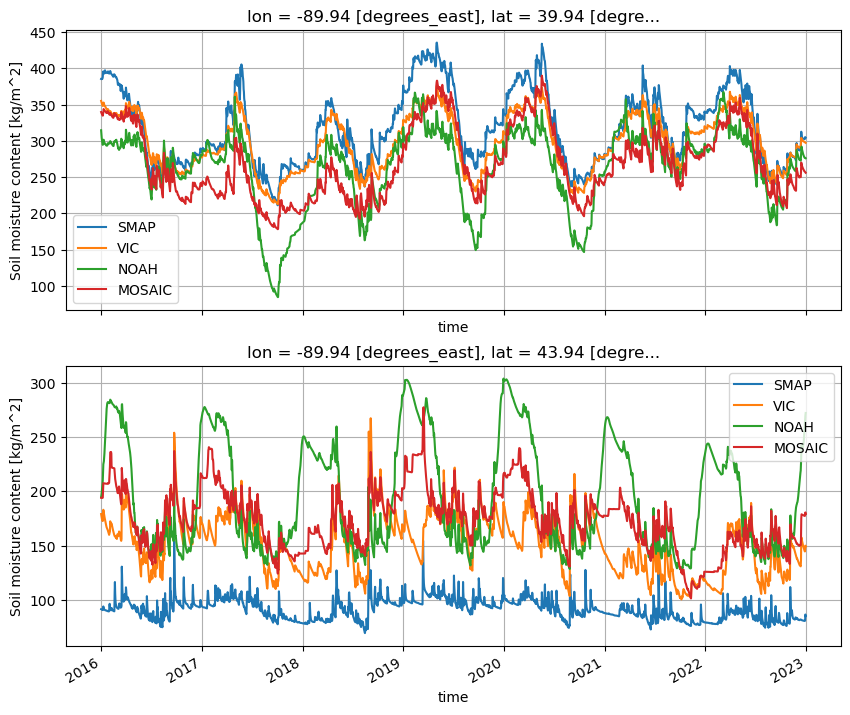

In [37]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Locaion 1
ds_smap_test_loc1.plot(ax=axs[0], label="SMAP")
ds_vic_test_loc1.plot(ax=axs[0], label="VIC")
ds_noah_test_loc1_rz.plot(ax=axs[0], label="NOAH")
ds_mosaic_test_loc1_rz.plot(ax=axs[0], label="MOSAIC")
axs[0].grid()
axs[0].legend()

# Locaion 2
ds_smap_test_loc2.plot(ax=axs[1], label="SMAP")
ds_vic_test_loc2.plot(ax=axs[1], label="VIC")
ds_noah_test_loc2_rz.plot(ax=axs[1], label="NOAH")
ds_mosaic_test_loc2_rz.plot(ax=axs[1], label="MOSAIC")
axs[1].grid()
axs[1].legend()

plt.show()

In [38]:
# Weekly anomalies
def get_weekly_anomaly(ds):
    ds_tmp = ds.copy()
    ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
    return ds_tmp.groupby("week") - ds_tmp.groupby("week").mean("time")

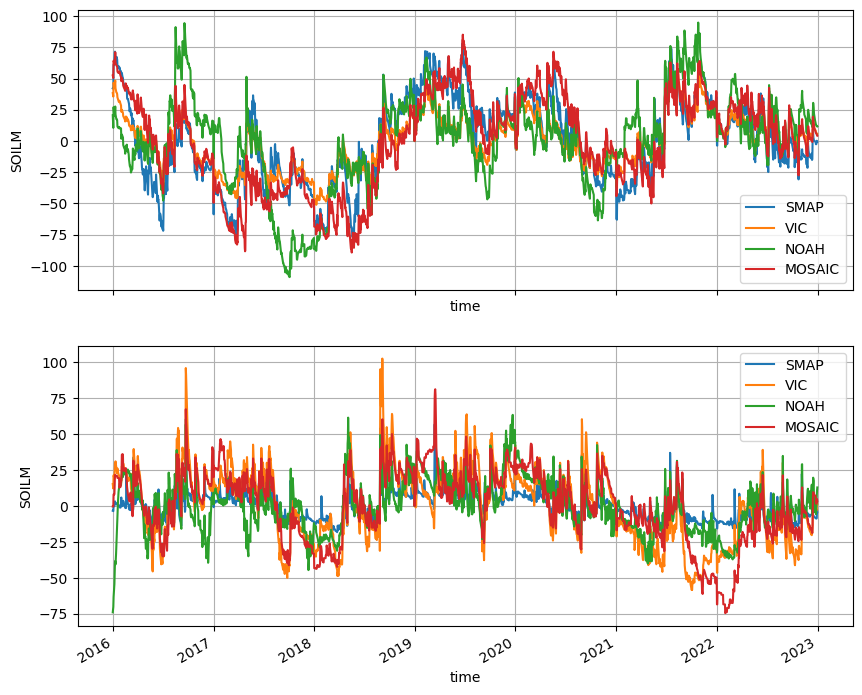

In [40]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Locaion 1
get_weekly_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label="SMAP")
get_weekly_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label="VIC")
get_weekly_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label="NOAH")
get_weekly_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label="MOSAIC")
axs[0].grid()
axs[0].legend()

# Locaion 2
get_weekly_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label="SMAP")
get_weekly_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label="VIC")
get_weekly_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label="NOAH")
get_weekly_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label="MOSAIC")
axs[1].grid()
axs[1].legend()

plt.show()

In [41]:
# Rolling (window*2)-day anomalies
def get_rolling_anomaly(ds, window=10):
    ds_tmp = ds.copy()

    # Calculate climatology
    ds_clima = []

    for doy in range(1, 366):
        doys = [
            365 + doy if doy <= 0 else doy
            for doy in np.arange(doy - window, doy + window + 1)
        ]
        tmp = ds.where(ds.time.dt.dayofyear.isin(doys)).mean(dim="time")
        ds_clima.append(tmp.assign_coords(doy=doy))

    ds_clima = xr.concat(ds_clima, dim="doy")

    # Remove clima
    ds_tmp = ds_tmp.assign_coords(doy=ds_tmp.time.dt.dayofyear)
    return ds_tmp.groupby("doy") - ds_clima

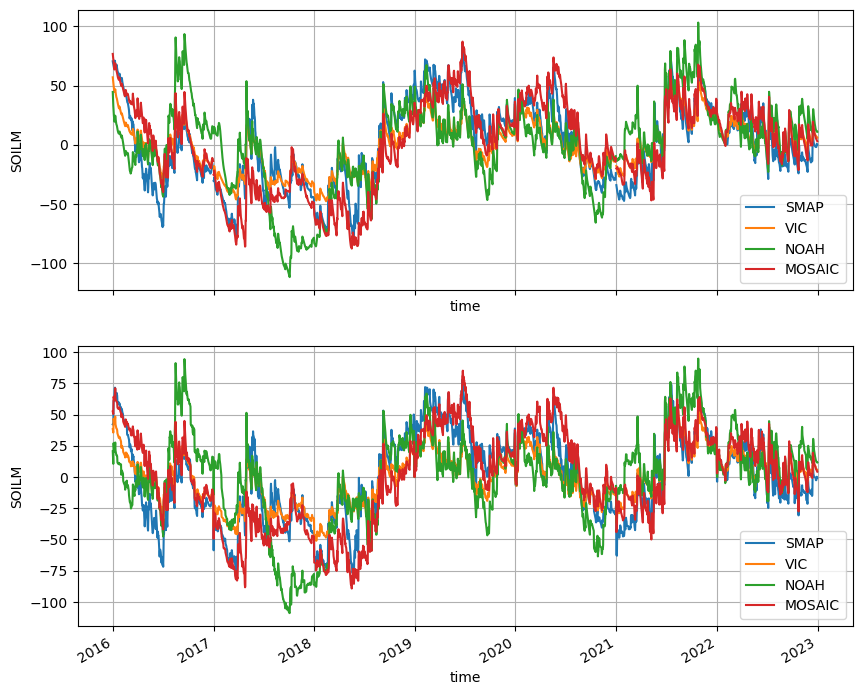

In [42]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Locaion 1
get_rolling_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label="SMAP")
get_rolling_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label="VIC")
get_rolling_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label="NOAH")
get_rolling_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label="MOSAIC")
axs[0].grid()
axs[0].legend()

# # Locaion 2
# get_rolling_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label='SMAP')
# get_rolling_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label='VIC')
# get_rolling_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label='NOAH')
# get_rolling_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label='MOSAIC')

# Locaion 2
get_weekly_anomaly(ds_smap_test_loc1).plot(ax=axs[1], label="SMAP")
get_weekly_anomaly(ds_vic_test_loc1).plot(ax=axs[1], label="VIC")
get_weekly_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[1], label="NOAH")
get_weekly_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[1], label="MOSAIC")
axs[1].grid()
axs[1].legend()

plt.show()

In [43]:
# Weekly standardized anomalies
def get_weekly_stnd_anomaly(ds):
    ds_tmp = ds.copy()
    ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
    return (ds_tmp.groupby("week") - ds_tmp.groupby("week").mean("time")).groupby(
        "week"
    ) / ds_tmp.groupby("week").std("time")

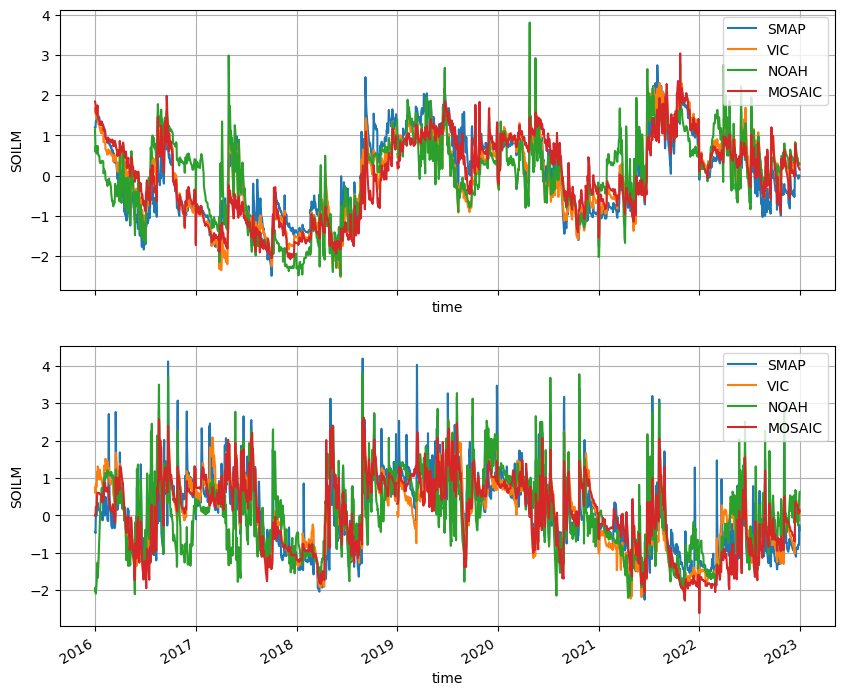

In [44]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Locaion 1
get_weekly_stnd_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label="SMAP")
get_weekly_stnd_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label="VIC")
get_weekly_stnd_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label="NOAH")
get_weekly_stnd_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label="MOSAIC")
axs[0].grid()
axs[0].legend()

# Locaion 2
get_weekly_stnd_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label="SMAP")
get_weekly_stnd_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label="VIC")
get_weekly_stnd_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label="NOAH")
get_weekly_stnd_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label="MOSAIC")
axs[1].grid()
axs[1].legend()

plt.show()

# Soil information

## Content fractions

In [11]:
# Read soil clay, sand, silt, fractions
def _preprocess(ds, name):
    ds_tmp = ds.isel(band=0).rename({"x": "lon", "y": "lat"})
    ds_tmp = ds_tmp.drop_vars(["band", "spatial_ref"])
    ds_tmp = ds_tmp.sortby("lat")
    ds_tmp = ds_tmp.rename({"band_data": name})
    return ds_tmp


ds_clayfrac = _preprocess(
    xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/clay_latlon.tif"), "clayfrac"
)
ds_siltfrac = _preprocess(
    xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/silt_latlon.tif"), "siltfrac"
)
ds_sandfrac = _preprocess(
    xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/sand_latlon.tif"), "sandfrac"
)

In [4]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(
    f"{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc"
)  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset({"lat": (["lat"], nldas_lat_grid,
                             {"standard_name": "latitude", "units": "degrees_north"},),
                     "lon": (["lon"], nldas_lon_grid,
                             {"standard_name": "longitude", "units": "degrees_east"},),
                    }
                   )

In [5]:
%%time
# Construct regridder (same for all)
regridder = xe.Regridder(ds_clayfrac, ds_out, "conservative")

CPU times: user 8min 38s, sys: 41.5 s, total: 9min 19s
Wall time: 9min 23s


In [6]:
# Re-grid and store

# NOTE: soil property (1km) has many NaNs over water so we skip these unless
# they make up 99% of the NLDAS grid point (this is a very high threshold just
# make sure there are no NaNs on the soil property map that would propagate through
# all the simulations. The NLDAS NaNs will remain when we calibrate.

ds_clayfrac_out = regridder(ds_clayfrac, skipna=True, na_thres=0.99)
ds_clayfrac_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/clayfrac_NLDASgrid.nc")

ds_siltfrac_out = regridder(ds_siltfrac, skipna=True, na_thres=0.99)
ds_siltfrac_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/siltfrac_NLDASgrid.nc")

ds_sandfrac_out = regridder(ds_sandfrac, skipna=True, na_thres=0.99)
ds_sandfrac_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/sandfrac_NLDASgrid.nc")

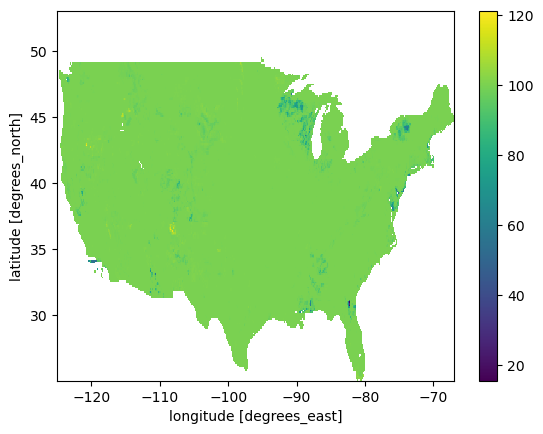

In [16]:
(ds_clayfrac_out.clayfrac + ds_sandfrac_out.sandfrac + ds_siltfrac_out.siltfrac).plot()

## Available water capacity & wilting point

### VIC

In [4]:
# VIC soil moisture extrema
ds_vic = xr.open_mfdataset('/storage/group/pches/default/public/NLDAS/VIC/daily/*.nc')

ds_vic_min = ds_vic.isel(depth=0)['SOILM0_100cm'].min(dim='time').compute()
ds_vic_max = ds_vic.isel(depth=0)['SOILM0_100cm'].max(dim='time').compute()

In [5]:
# Store
ds_vic_range = ds_vic_max - ds_vic_min

xr.Dataset({'wiltingp': ds_vic_min}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_wiltingp.nc")
xr.Dataset({'awCap': ds_vic_range}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_awCap.nc")

### Old VIC

In [12]:
# # NLDAS soil types
# ds_nldas = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/NLDAS_masks-veg-soil.nc4")

In [5]:
# # Separate and save
# soils = [
#     'sand',
#     'loamy_sand',
#     'sandy_loam',
#     'silt_loam',
#     'silt',
#     'loam',
#     'sandy_clay_loam',
#     'silty_clay_loam',
#     'clay_loam',
#     'sandy_clay',
#     'silty_clay',
#     'clay']

# for idx, soil in enumerate(soils):
#     xr.Dataset({soil: (ds_nldas['NLDAS_soil'] == (idx + 1))}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/NLDAS_{soil}.nc")

In [8]:
# # Taken from the only damn source I could find for VIC: https://zenodo.org/records/2612560
# # Paper: https://doi.org/10.1038/s41597-019-0150-2
# # CONUS parameters from: https://doi.org/10.1175/JCLI-D-12-00508.1
# # See also: https://www.nature.com/articles/s41597-021-00999-4
# ds_vic_info = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/params.CONUS_MX.L2015.nc")

In [1]:
# (ds_vic_info['depth'].sum(dim='nlayer')).plot()

In [2]:
# # Total VIC depth
# ds_vic_depth = ds_vic_info['depth'].sum(dim='nlayer')

# # Get NLDAS grid
# nldas_lon_grid = ds_nldas.lon.to_numpy()
# nldas_lat_grid = ds_nldas.lat.to_numpy()

# ds_out = xr.Dataset({"lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
#                      "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"})})

# # Regrid conservatively
# regridder = xe.Regridder(ds_vic_depth, ds_out, "conservative")

# vic_depth_nldas = regridder(ds_vic_depth, skipna=True, na_thres=0.99) # This threshold is somewhat subjective
# vic_wpfrac_nldas = regridder(ds_vic_info['Wpwp_FRACT'].isel(nlayer=0), skipna=True, na_thres=0.99)
# vic_wcrfrac_nldas = regridder(ds_vic_info['Wcr_FRACT'].isel(nlayer=0), skipna=True, na_thres=0.99)
# vic_awcap_nldas = (vic_wcrfrac_nldas / 0.7) - vic_wpfrac_nldas

# vic_depth_nldas_capped = xr.where(vic_depth_nldas <= 1., vic_depth_nldas, 1.)
# # xr.Dataset({'rootDepth':vic_depth_nldas_capped}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_rootDepth.nc")

# # xr.Dataset({'wiltingp_frac':vic_wpfrac_nldas}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_wiltingp_frac.nc")
# # xr.Dataset({'awCap_frac':vic_awcap_nldas}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_awCap_frac.nc")

In [14]:
# # VIC soil parameters from https://vic.readthedocs.io/en/vic.4.2.d/Documentation/soiltext/
# # Accessed Feb 2024
# # Originally from "Average hydraulic properties of ARS soil texture classes" draft dated February, 2000 by J. Schaake

# fieldCap_map = {
#         1: 0.08, # SAND
#         2: 0.15, # LOAMY SAND
#         3: 0.21, # SANDY LOAM
#         4: 0.32, # SILT LOAM
#         5: 0.28, # SILT
#         6: 0.29, # LOAM
#         7: 0.27, # SANDY CLAY LOAM
#         8: 0.36, # SILTY CLAY LOAM
#         9: 0.34, # CLAY LOAM
#         10: 0.31, #  SANDY CLAY
#         11: 0.37, #  SILTY CLAY
#         12: 0.36, #  CLAY
#     }

# wiltingp_map = {
#         1: 0.03, # SAND
#         2: 0.06, # LOAMY SAND
#         3: 0.09, # SANDY LOAM
#         4: 0.12, # SILT LOAM
#         5: 0.08, # SILT
#         6: 0.14, # LOAM
#         7: 0.17, # SANDY CLAY LOAM
#         8: 0.21, # SILTY CLAY LOAM
#         9: 0.21, # CLAY LOAM
#         10: 0.23, #  SANDY CLAY
#         11: 0.25, #  SILTY CLAY
#         12: 0.27, #  CLAY
#     }

# porosity_map = {
#         1: 0.43, # SAND
#         2: 0.42, # LOAMY SAND
#         3: 0.4, # SANDY LOAM
#         4: 0.46, # SILT LOAM
#         5: 0.52, # SILT
#         6: 0.43, # LOAM
#         7: 0.39, # SANDY CLAY LOAM
#         8: 0.48, # SILTY CLAY LOAM
#         9: 0.46, # CLAY LOAM
#         10: 0.41, #  SANDY CLAY
#         11: 0.49, #  SILTY CLAY
#         12: 0.47, #  CLAY
#     }

In [32]:
# # Construct maps
# rootDepth = vic_depth_nldas_capped * 1000
# # rootDepth = vic_depth_nldas * 1000
# ds_vic_porosity = ds_nldas['NLDAS_soil'].copy(data=np.vectorize(lambda x: porosity_map.get(x, np.nan))(ds_nldas['NLDAS_soil']))
# ds_vic_max_soilM = rootDepth * ds_vic_porosity # max soilMoisture of total layer

# ds_vic_fieldCap = ds_vic_max_soilM * ds_nldas['NLDAS_soil'].copy(data=np.vectorize(lambda x: fieldCap_map.get(x, np.nan))(ds_nldas['NLDAS_soil']))
# ds_vic_wiltingp = ds_vic_max_soilM * ds_nldas['NLDAS_soil'].copy(data=np.vectorize(lambda x: wiltingp_map.get(x, np.nan))(ds_nldas['NLDAS_soil']))
# ds_vic_awCap = ds_vic_fieldCap - ds_vic_wiltingp

# # ds_vic_fieldCap_por = ds_nldas['NLDAS_soil'].copy(data=np.vectorize(lambda x: fieldCap_map.get(x, np.nan))(ds_nldas['NLDAS_soil']))
# # ds_vic_wiltingp_por = ds_nldas['NLDAS_soil'].copy(data=np.vectorize(lambda x: wiltingp_map.get(x, np.nan))(ds_nldas['NLDAS_soil']))
# # ds_vic_awCap_por = ds_vic_fieldCap_por - ds_vic_wiltingp_por

# # # Store
# # xr.Dataset({'awCap': ds_vic_awCap}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_awCap.nc")
# # xr.Dataset({'wiltingp': ds_vic_wiltingp}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_wiltingp.nc")

In [94]:
# # Store
# xr.Dataset({'awCap': ds_vic_awCap}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_awCap.nc")
# xr.Dataset({'wiltingp': ds_vic_wiltingp}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/VIC_wiltingp.nc")

### NOAH

In [10]:
# # Read NOAH soil properties
# ds_noah = xr.open_dataset(f"{nldas_path}/NOAH/constants/NLDAS_soil_Noah.nc4")

In [29]:
# # Calculate awCap in mm/m
# awCap = (
#     (1000 * (ds_noah["Noah_fieldcap"] - ds_noah["Noah_wiltingp"]))
#     .isel(time=0)
#     .drop("time")
# )
# ds_awCap = xr.Dataset({"awCap": awCap})

# ds_awCap.awCap.attrs["units"] = "mm/m"
# ds_awCap.awCap.attrs["note"] = "Calculated as NOAH field capacity minus wilting point"

# # Store
# ds_awCap.to_netcdf(f"{project_data_path}/WBM/geo_inputs/NOAH_awCap.nc")

In [30]:
# # Wilting point in mm/m
# wp = 1000 * ds_noah["Noah_wiltingp"].isel(time=0).drop("time")
# ds_wp = xr.Dataset({"wiltingp": wp})

# ds_wp.wiltingp.attrs["units"] = "mm/m"
# ds_wp.wiltingp.attrs["note"] = "Calculated from MOSAIC"

# # Store
# ds_wp.to_netcdf(f"{project_data_path}/WBM/geo_inputs/NOAH_wiltingp.nc")

In [6]:
# NOAH soil mositure extrema 
ds_noah = xr.open_mfdataset(f'{nldas_path}/NOAH/daily/*.nc')

ds_noah_min = ds_noah["SOILM"].isel(depth=1).min(dim='time').compute()
ds_noah_max = ds_noah["SOILM"].isel(depth=1).max(dim='time').compute()

ds_noah_range = ds_noah_max - ds_noah_min

# Store
xr.Dataset({'wiltingp': ds_noah_min}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/NOAH_wiltingp.nc")
xr.Dataset({'awCap': ds_noah_range}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/NOAH_awCap.nc")

### MOSAIC

In [3]:
# # Read MOSAIC soil properties
# ds_mosaic = xr.open_dataset(f"{nldas_path}/MOSAIC/constants/NLDAS_soil_Mosaic.nc4")

In [17]:
# # Calculate awCap in mm/m
# awCap = (
#     (1000 * (ds_mosaic["Mosaic_field3"] - ds_mosaic["Mosaic_wiltingp"]))
#     .isel(time=0)
#     .drop("time")
# )
# ds_awCap = xr.Dataset({"awCap": awCap})

# ds_awCap.awCap.attrs["units"] = "mm/m"
# ds_awCap.awCap.attrs[
#     "note"
# ] = "Calculated as MOSAIC field capacity (depth 3) minus wilting point"

# # Store
# ds_awCap.to_netcdf(f"{project_data_path}/WBM/geo_inputs/MOSAIC_awCap.nc")

In [18]:
# # Wilting point in mm/m
# wp = 1000 * ds_mosaic["Mosaic_wiltingp"].isel(time=0).drop("time")
# ds_wp = xr.Dataset({"wiltingp": wp})

# ds_wp.wiltingp.attrs["units"] = "mm/m"
# ds_wp.wiltingp.attrs["note"] = "Calculated from MOSAIC"

# # Store
# ds_wp.to_netcdf(f"{project_data_path}/WBM/geo_inputs/MOSAIC_wiltingp.nc")

In [7]:
# MOSAIC soil mositure extrema 
ds_mosaic = xr.open_mfdataset(f'{nldas_path}/MOSAIC/daily/*.nc')

ds_mosaic_min = ds_mosaic["SOILM"].isel(depth=1).min(dim='time').compute()
ds_mosaic_max = ds_mosaic["SOILM"].isel(depth=1).max(dim='time').compute()

ds_mosaic_range = ds_mosaic_max - ds_mosaic_min

# Store
xr.Dataset({'wiltingp': ds_mosaic_min}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/MOSAIC_wiltingp.nc")
xr.Dataset({'awCap': ds_mosaic_range}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/MOSAIC_awCap.nc")

### SMAP

In [8]:
# SMAP soil mositure extrema 
ds_smap = xr.open_mfdataset(f"{smap_path}/processed_nldas_grid/*.nc")

ds_smap_min = ds_smap["sm_rootzone"].min(dim='time').compute()
ds_smap_max = ds_smap["sm_rootzone"].max(dim='time').compute()

ds_smap_range = ds_smap_max - ds_smap_min

# Store
xr.Dataset({'wiltingp': 1000 * ds_smap_min}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/SMAP_wiltingp.nc")
xr.Dataset({'awCap': 1000 * ds_smap_range}).to_netcdf(f"{project_data_path}/WBM/geo_inputs/SMAP_awCap.nc")

In [12]:
# # Read SMAP land constants
# # wiltingp
# ds_smap_wiltingp = xr.open_dataset(
#     f"{smap_path}/constants/raw_regridded/SMAP_L4_SM_lmc_00000000T000000_Vv7030_001_Land-Model-Constants_Data_clsm_wp_35a4d5ce.tif"
# )
# ds_smap_wiltingp_in = ds_smap_wiltingp.sortby("y").sel(y=slice(20, 60), x=slice(-130, -60))  # generous North America slice
# ds_smap_wiltingp_in = ds_smap_wiltingp_in.rename({"x": "lon", "y": "lat"})
# ds_smap_wiltingp_in = ds_smap_wiltingp_in.isel(band=0).drop_vars(["band", "spatial_ref"])

# # awCap
# ds_smap_por = xr.open_dataset(f"{smap_path}/constants/raw_regridded/SMAP_L4_SM_lmc_00000000T000000_Vv7030_001_Land-Model-Constants_Data_clsm_poros_35a4d5ce.tif")
# ds_smap_por_in = ds_smap_por.sortby("y").sel(y=slice(20, 60), x=slice(-130, -60))  # generous North America slice
# ds_smap_por_in = ds_smap_por_in.rename({"x": "lon", "y": "lat"})
# ds_smap_por_in = ds_smap_por_in.isel(band=0).drop_vars(["band", "spatial_ref"])

In [13]:
# # Get NLDAS grid
# nldas_grid = xr.open_dataset(
#     f"{nldas_path}/VIC/daily/NLDAS_VIC0125_H.A20221231.nc"
# )  # random date

# nldas_lon_grid = nldas_grid.lon.to_numpy()
# nldas_lat_grid = nldas_grid.lat.to_numpy()

# # Regrid conservatively
# ds_out = xr.Dataset({
#         "lat": (["lat"], nldas_lat_grid,
#                 {"standard_name": "latitude", "units": "degrees_north"},),
#         "lon": (["lon"], nldas_lon_grid,
#                 {"standard_name": "longitude", "units": "degrees_east"},),
# })
# # Add mask from NLDAS output (otherwise weird NaN behavior)
# ds_out["mask"] = xr.where(~np.isnan(nldas_grid["RZSM"].isel(lev_2=0, time=0)), 1, 0)
# ds_out = ds_out.drop_vars(["time", "lev_2"])

In [14]:
# # Regrid conservatively
# regridder = xe.Regridder(ds_smap_wiltingp_in, ds_out, "conservative")

# # Store
# wiltingp = regridder(ds_smap_wiltingp_in, skipna=True, na_thres=0.5)["band_data"] * 1000
# ds_smap_wiltingp_out = xr.Dataset({"wiltingp": wiltingp})
# ds_smap_wiltingp_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/SMAP_wiltingp.nc")

# ds_smap_por_in = ds_smap_por_in.where(ds_smap_por_in["band_data"] < 0.93) # Filter out large porosity values (at max. of allowed)
# por = regridder(ds_smap_por_in, skipna=True, na_thres=0.5)["band_data"] * 1000
# ds_smap_awCap_out = xr.Dataset({"awCap": por - wiltingp})
# ds_smap_awCap_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/SMAP_awCap.nc")

# Leaf Area Index

## MODIS

In [3]:
# MODIS MCD15A3H v061: https://lpdaac.usgs.gov/products/mcd15a3hv061/
ds_lai = xr.open_dataset(f"{lai_path}/MCD15A3H.061_500m_aid0001.nc", chunks='auto')

In [4]:
# Interpolatet to daily
ds_lai = ds_lai.resample(time="1D").interpolate("linear")

In [ ]:
%%time 
# Get NLDAS grid
nldas_grid = xr.open_dataset(
    f"{nldas_path}/VIC/daily/NLDAS_VIC0125_H.A20221231.nc"
)  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset(
    {
        "lat": (
            ["lat"],
            nldas_lat_grid,
            {"standard_name": "latitude", "units": "degrees_north"},
        ),
        "lon": (
            ["lon"],
            nldas_lon_grid,
            {"standard_name": "longitude", "units": "degrees_east"},
        ),
    }
)
# Add mask from NLDAS output (otherwise weird NaN behavior)
ds_out["mask"] = xr.where(~np.isnan(nldas_grid["RZSM"].isel(lev_2=0, time=0)), 1, 0)
ds_out = ds_out.drop_vars(["time", "lev_2"])

# Build regridder
regridder = xe.Regridder(ds_lai['Lai_500m'].isel(time=0), ds_out, "conservative")

In [ ]:
%%time
# NOTE: use high NaN threshold to try to not introduce NaNs
# not already present in the NLDAS grid
ds_lai_out = regridder(ds_lai['Lai_500m'], skipna=True, na_thres=0.99)

In [ ]:
# Rename
ds_lai_out = xr.Dataset({'LAI': ds_lai_out})

# Store
ds_lai_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/LAI_MODIS_NLDASgrid.nc")

## GLDAS

In [50]:
# GLDAS LAI based on AVHRR satellite, 20-year climatology from 1982 - 2001
# See: https://ldas.gsfc.nasa.gov/gldas/lai-greenness
ds_lai = xr.open_dataset(
    f"{project_data_path}/WBM/geo_inputs/GLDASp5_CLSM_lai_025d.nc4", decode_times=False
)

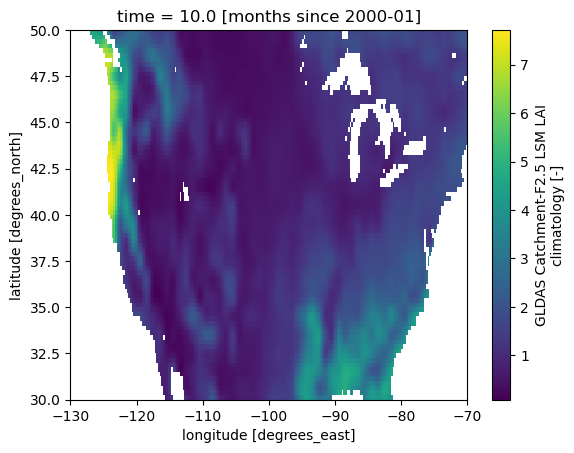

In [51]:
ds_lai.isel(time=10)["GLDAS_Catchment-F2.5_LAI"].sel(
    lat=slice(30, 50), lon=slice(-130, -70)
).plot()

In [55]:
# Fix time coordinate
ds_lai["time"] = pd.date_range("2000-01-01", periods=12, freq="MS")

# Wrap and append
ds_lai_end = ds_lai.isel(time=0)
ds_lai_end["time"] = pd.date_range("2001-01-01", periods=1, freq="MS")

ds_lai = xr.concat([ds_lai, ds_lai_end], dim='time')

In [57]:
# Interpolatet to daily
ds_lai = ds_lai.resample(time="1D").interpolate("linear")

In [65]:
# Slice to 365 day calendar
ds_lai = ds_lai.convert_calendar(calendar = 'noleap', dim='time').sel(time=slice('2000-01-01', '2000-12-31'))

In [71]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(
    f"{nldas_path}/VIC/daily/NLDAS_VIC0125_H.A20221231.nc"
)  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset(
    {
        "lat": (
            ["lat"],
            nldas_lat_grid,
            {"standard_name": "latitude", "units": "degrees_north"},
        ),
        "lon": (
            ["lon"],
            nldas_lon_grid,
            {"standard_name": "longitude", "units": "degrees_east"},
        ),
    }
)
# Add mask from NLDAS output (otherwise weird NaN behavior)
ds_out["mask"] = xr.where(~np.isnan(nldas_grid["RZSM"].isel(lev_2=0, time=0)), 1, 0)
ds_out = ds_out.drop_vars(["time", "lev_2"])

# NOTE: use bilinear since we are increasing resolution
# and again use high NaN threshold to try to not introduce NaNs
# not already present in the NLDAS grid (there will still be a few here)
regridder = xe.Regridder(ds_lai, ds_out, "bilinear")
ds_lai_out = regridder(ds_lai, skipna=True, na_thres=0.99)

# Rename
ds_lai_out = ds_lai_out.rename({"GLDAS_Catchment-F2.5_LAI": "LAI"})

# Store
ds_lai_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/LAI_GLDAS_clima_NLDASgrid.nc")

In [3]:
ds = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/LAI_GLDAS_clima_NLDASgrid.nc")

# Land use types

## Cropland

In [12]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(
    f"{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc"
)  # random date

nldas_lat_min = nldas_grid.lat.min()
nldas_lon_min = nldas_grid.lon.min()
nldas_lat_max = nldas_grid.lat.max()
nldas_lon_max = nldas_grid.lon.max()

# grid same in lat/lon
assert (nldas_grid.lat[1] - nldas_grid.lat[0]) == (
    nldas_grid.lon[1] - nldas_grid.lon[0]
)

nldas_spacing = nldas_grid.lat[1] - nldas_grid.lat[0]

In [15]:
# Define edges and centers
low_lon_edges = np.arange(nldas_lon_min - nldas_spacing / 2,
                          nldas_lon_max + nldas_spacing,
                          nldas_spacing)

low_lat_edges = np.arange(nldas_lat_min - nldas_spacing / 2,
                          nldas_lat_max + nldas_spacing,
                          nldas_spacing)

lon_centers = (low_lon_edges[:-1] + low_lon_edges[1:]) / 2
lat_centers = (low_lat_edges[:-1] + low_lat_edges[1:]) / 2

In [19]:
# Preprocessing of CDL data
def _preprocess(ds):
    # Add time dimension
    ds = ds.assign_coords(time=int(ds.encoding["source"][59:63]))
    # Rename
    ds = ds.rename({"band_data": "CDL_value", "x": "lon", "y": "lat"}).sortby("lat")
    # Drop band
    ds = ds.isel(band=0).drop_vars("band")

    return ds

In [20]:
# Only include major US crops listed in Siebert & Döll (2010): https://www.sciencedirect.com/science/article/pii/S0022169409004235
def map_CDL_crops(ds):
    # Crop codes
    crop_codes = {
        "corn": 1,
        "cotton": 2,
        "rice": 3,
        "sorghum": 4,
        "soybeans": 5,
        "durum_wheat": 22,
        "spring_wheat": 23,
        # "winter_wheat": 24,
    }

    # Map over all
    ds_dict_out = {}
    for key, value in crop_codes.items():
        ds_dict_out[key] = ds.CDL_value == value

    # Return
    return xr.Dataset(ds_dict_out)

In [8]:
# Read all
ds = xr.open_mfdataset("/storage/group/pches/default/users/dcl5300/USDA_CDL/latlon/20*_30m_cdls.tif",
                       chunks="auto", 
                       preprocess=_preprocess,
                       combine = "nested", concat_dim = "time")

In [9]:
%%time
# Lazy computation 
CDL_agg = (
    map_CDL_crops(ds)
    .groupby_bins("lon", bins=low_lon_edges, labels=lon_centers)
    .mean(dim="lon")
    .groupby_bins("lat", bins=low_lat_edges, labels=lat_centers)
    .mean(dim="lat")
)

CPU times: user 2.37 s, sys: 80 ms, total: 2.45 s
Wall time: 2.58 s


In [10]:
%%time
# Store
CDL_agg.to_netcdf(f"{project_data_path}/WBM/geo_inputs/CDL_MajorCropsFrac_2016-2022_NLDASgrid.nc")

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 16.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 5min 19s, sys: 19.6 s, total: 5min 39s
Wall time: 17min 59s


In [11]:
# Final
CDL_agg = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL_MajorCropsFrac_2016-2022_NLDASgrid.nc")
CDL_agg_final = CDL_agg.rename({'lat_bins':'lat', 'lon_bins':'lon'}).mean(dim='time')

# Get remainder
CDL_agg_final['other'] = 1. - (CDL_agg_final['corn'] + \
                        CDL_agg_final['cotton'] + \
                        CDL_agg_final['rice'] + \
                        CDL_agg_final['sorghum'] + \
                        CDL_agg_final['soybeans'] + \
                        CDL_agg_final['durum_wheat'] + \
                        CDL_agg_final['spring_wheat'])
                        # CDL_agg_final['winter_wheat'])
# Store
CDL_agg_final.to_netcdf(f"{project_data_path}/WBM/geo_inputs/CDL_MajorCropsFrac_avg_NLDASgrid.nc")

## All

In [3]:
# Read crop
ds_cdl = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL_MajorCropsFrac_avg_NLDASgrid.nc")

In [4]:
# Read NLDAS
ds_nldas = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/NLDAS_veg-freq.nc4")

# Regrid to 'correct' NLDAS grid (this netCDF is slightly differenent from the forcing/outputs??)
nldas_grid = xr.open_dataset(f"{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc")  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid NN
ds_out = xr.Dataset({"lat": (["lat"], nldas_lat_grid,
                    {"standard_name": "latitude", "units": "degrees_north"}),
                     "lon": (["lon"], nldas_lon_grid,
                    {"standard_name": "longitude", "units": "degrees_east"})})

regridder = xe.Regridder(ds_nldas, ds_out, "nearest_s2d")
ds_nldas_out = regridder(ds_nldas)

# Rename NLDAS
index_to_name = {
    "NLDAS_veg0_f": "Water",
    "NLDAS_veg1_f": "Evergreen Needleleaf Forest",
    "NLDAS_veg2_f": "Evergreen Broadleaf Forest",
    "NLDAS_veg3_f": "Deciduous Needleleaf Forest",
    "NLDAS_veg4_f": "Deciduous Broadleaf Forest",
    "NLDAS_veg5_f": "Mixed Cover",
    "NLDAS_veg6_f": "Woodland",
    "NLDAS_veg7_f": "Wooded Grassland",
    "NLDAS_veg8_f": "Closed Shrubland",
    "NLDAS_veg9_f": "Open Shrubland",
    "NLDAS_veg10_f":  "Grassland",
    "NLDAS_veg11_f":  "Cropland",
    "NLDAS_veg12_f":  "Bare Ground",
    "NLDAS_veg13_f":  "Urban and Built-Up"}

ds_nldas_out = ds_nldas_out.rename(index_to_name)

In [19]:
# Merge
ds_all = xr.merge([ds_nldas_out.isel(time=0).sortby('lat'), ds_cdl.sortby('lat')], join='override')

In [22]:
# CDL fractions are assumed correct as fraction of NLDAS `cropland`
# Remaining `cropland` from NLDAS is set to `cropland_other`

# Scale the CDL crops to NLDAS cropland fraction
ds_all['corn_scaled'] = ds_all['corn'] * ds_all['Cropland']
ds_all['cotton_scaled'] = ds_all['cotton'] * ds_all['Cropland']
ds_all['rice_scaled'] = ds_all['rice'] * ds_all['Cropland']
ds_all['sorghum_scaled'] = ds_all['sorghum'] * ds_all['Cropland']
ds_all['soybeans_scaled'] = ds_all['soybeans'] * ds_all['Cropland']
ds_all['durum_wheat_scaled'] = ds_all['durum_wheat'] * ds_all['Cropland']
ds_all['spring_wheat_scaled'] = ds_all['spring_wheat'] * ds_all['Cropland']
# ds_all['winter_wheat_scaled'] = ds_all['winter_wheat'] * ds_all['Cropland']

# Other cropland (and fill NaNs)
ds_all['cropland_other'] = ds_all['Cropland'] - (ds_all['corn_scaled'] + \
                                                    ds_all['cotton_scaled'] + \
                                                    ds_all['rice_scaled'] + \
                                                    ds_all['sorghum_scaled'] + \
                                                    ds_all['soybeans_scaled'] + \
                                                    ds_all['durum_wheat_scaled'] + \
                                                    ds_all['spring_wheat_scaled'])
                                                    # ds_all['winter_wheat_scaled'])
ds_all['cropland_other'] = xr.where(ds_all['cropland_other'].isnull(), ds_all['Cropland'], ds_all['cropland_other'])

In [23]:
# Take final categories and rename
final_names = {"corn_scaled": "corn",
              "cotton_scaled": "cotton",
              "rice_scaled": "rice",
              "sorghum_scaled": "sorghum",
              "soybeans_scaled": "soybeans",
              "durum_wheat_scaled": "durum_wheat",
              "spring_wheat_scaled": "spring_wheat",
              # "winter_wheat_scaled": "winter_wheat",
              "cropland_other": "cropland_other",
              "Water": "water",
              "Evergreen Needleleaf Forest": "evergreen_needleleaf",
              "Evergreen Broadleaf Forest": "evergreen_broadleaf",
              "Deciduous Needleleaf Forest": "deciduous_needleleaf",
              "Deciduous Broadleaf Forest": "deciduous_broadleaf",
              "Mixed Cover": "mixed_forest",
              "Woodland": "woodland",
              "Wooded Grassland": "wooded_grassland",
              "Closed Shrubland": "closed_shurbland",
              "Open Shrubland": "open_shrubland",
              "Grassland": "grassland",
              "Bare Ground": "barren",
              "Urban and Built-Up": "urban"}

ds_out = ds_all[final_names.keys()]
ds_out = ds_out.rename(final_names)

In [26]:
# Store
ds_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

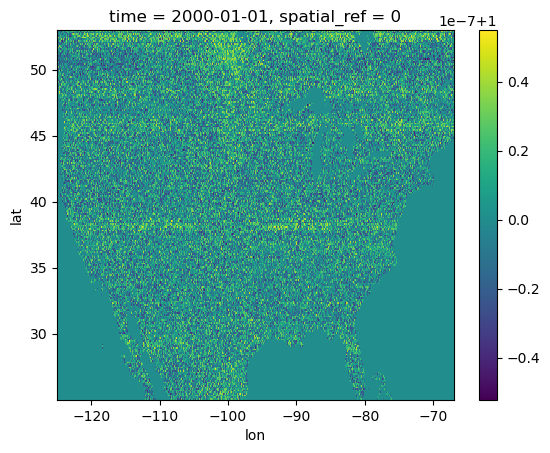

In [25]:
# Check sum
ds_out.to_array().sum("variable").plot()

# Elevation data

In [11]:
# Read NLDAS
ds_in = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/NLDAS_elevation.nc4")

# Again need to regrid (??)
nldas_grid = xr.open_dataset(f"{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc")  # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid NN
ds_out = xr.Dataset({"lat": (["lat"], nldas_lat_grid,
                    {"standard_name": "latitude", "units": "degrees_north"}),
                     "lon": (["lon"], nldas_lon_grid,
                    {"standard_name": "longitude", "units": "degrees_east"})})

regridder = xe.Regridder(ds_in, ds_out, "nearest_s2d")
ds_nldas_el = regridder(ds_in)

In [ ]:
# Store elevation STD (can be useful for betaHBV param)
ds_out = ds_nldas_el[['NLDAS_elev_std']].isel(time=0)
ds_out = xr.where(ds_out < 0., 0., ds_out)
ds_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/NLDAS_elev_STD_NLDASgrid.nc")